In [9]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
from os.path import join # 디렉토리 연결을 위한 path join
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

Step 1. 스티커 구하기 or 만들기

In [10]:
# 디렉토리가 변경될 수 있으므로 사용될 이미지들과 모델의 디렉토리 위치를 지정
img_dir = './images'
model_dir = './models'
# 이미지,모델 변경 편리하도록 지정 
cat_file = 'cat-whiskers.png'
face_file = 'face.png'
model_file = 'shape_predictor_68_face_landmarks.dat'

Step 2. 얼굴 검출 & 랜드마크 검출 하기

In [11]:
# OpenCV로 이미지를 불러옵니다
# './images/face.png'
img_bgr = cv2.imread(join(img_dir,face_file))   
# 제 샘플이미지가 커서 조정
img_bgr = cv2.resize(img_bgr, (540,720))
# 출력용 이미지를 따로 보관합니다
img_show = img_bgr.copy()
# bgr이미지를 rgb로 변환함
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# PEP8 스네이크 케이스 지향 
# 사진에서 얼굴영역들 찾기
def get_dlib_rects(img_rgb):    
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

    # dlib.get_frontal_face_detector 얼굴감지기를 통해서 얼굴 위치의 사각형 박스를 찾음
    return detector_hog(img_rgb, 1)   # (image, num of image pyramid)
    
dlib_rects = get_dlib_rects(img_rgb)
print(dlib_rects)

rectangles[[(184, 270) (339, 425)]]


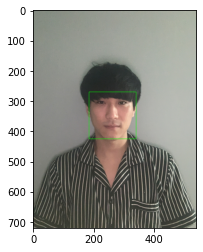

In [12]:
# dlib_rects는 한 사진에서 여러개의 얼굴 오브젝트를 찾을 수 있기때문에 여러개일수있음
# 그렇기때문에 for문을 사용해 각 영역별 얼굴을 가져와 봄
def fill_rectangle(image, dlib_rects, size = 1):
    for dr in dlib_rects: # 찾은 얼굴 영역의 좌표

        l = dr.left() # 왼쪽
        t = dr.top() # 위쪽
        r = dr.right() # 오른쪽
        b = dr.bottom() # 아래쪽

        cv2.rectangle(image, (l,t), (r,b), (0,255,0), size, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

fill_rectangle(img_show,dlib_rects)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
# 여기에서는 내얼굴 하나의 영역만 인식

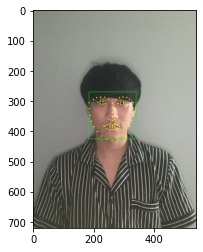

In [13]:
# 모델을 shape_predictor 함수를 이용해 얼굴영역의 디테일포인트들 찾기
landmark_predictor = dlib.shape_predictor(join(model_dir,model_file))

def fill_landmarks(image,dlib_rects):
    list_landmarks = []
    for dlib_rect in dlib_rects:
        # 검색이미지 img_rgb와 얼굴의 위치 dlib_rect를 전달해서 얼굴세부 포인트를 찾음
        points = landmark_predictor(img_rgb, dlib_rect)
        """
        map , lambda 문법을 풀어쓰면 하기와같이 쓸수 있음
        list_points = []
        for point in points.parts():
            x = point.x
            y = point.y
            list_points.append((x,y))
        print("list_points:" ,list_points)
        """
        # 모든 landmark의 위치정보를 points 변수에 저장
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 얼굴 마다 세부포인트들이 있기때문에 list_landmarks에 랜드마크 리스트를 저장
        list_landmarks.append(list_points)

    # list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(image, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
    return list_landmarks

list_landmarks = fill_landmarks(img_show,dlib_rects)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

Step 3. 스티커 적용 위치 확인하기

In [14]:
# 얼굴영역과 디테일좌표를 합침
# 여러개의 얼굴과 각 디테일이 있으면 여러번이겠지만 한개뿐이므로 한번 
for face,marks in zip(dlib_rects, list_landmarks) :
    x = marks[33][0] # 이미지에서 콧망울 부위의 x값
    y = marks[33][1] # 이미지에서 콧망울 부위의 y값
    w = h = face.width() # 수염 크기를 얼굴영역 사이즈와 동일하게 
    #w = (face.width() // 2) # 수염 크기를 얼굴사이즈 절반으로 잡음 수염사이즈가 절반으로 줄겠죠 ? 
    #h = (face.height() // 2) # 여기서 나눌떄 / 한개만 아니라 // 두개필요 정수 처리되어야함 
    print(face.width() / 2 , face.width() // 2)

78.0 78


(156, 156, 3)


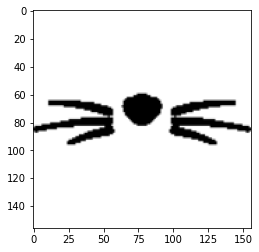

In [15]:
img_sticker = cv2.imread(join(img_dir,cat_file)) # 스티커 이미지를 불러옵니다 
# 정수사이즈로 리사이징 위에서 78.0 같은 값 들어오면 에러나유 
img_sticker = cv2.resize(img_sticker, (w,h))
# 넣을 이미지를 봐봄
print(img_sticker.shape)
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
# 시작위치를 잡아줌
# x , y 를 콧망울 위치로 잡았고 해당위치에 넣을 이미지의 중앙이 오게할것이기때문에 이미지사이즈를 절반 나눈걸 빼줌 
refined_x = x - (w // 2) # 269 - (156 / 2) = 184
refined_y = y - (h // 2) # 364 - (156 / 2) = 286
print(refined_x,refined_y)

184 286


In [17]:
# 위에서 말한것처럼 0 이하인경우 시작위치가 내사진 좌측상단꼭지점 (0,0)을 넘겼다는걸 의미함
# 그러므로 스티커 사진도 그만큼 잘라줌 
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    img_sticker = img_sticker[-refined_y:, :] 
    refined_y = 0

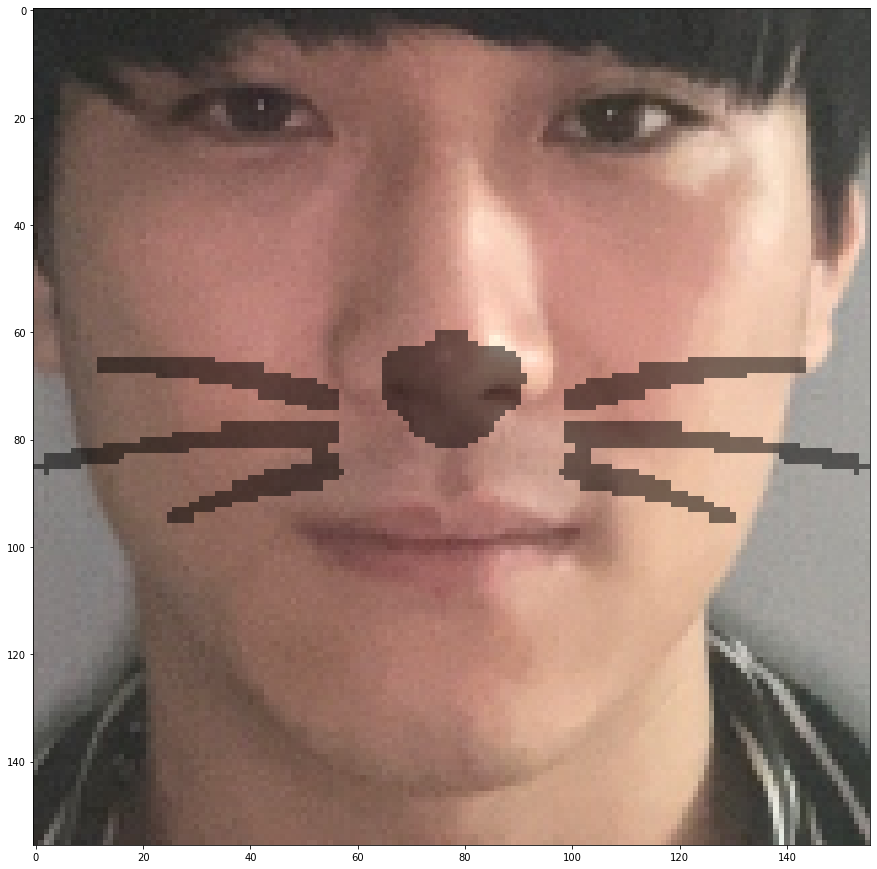

In [28]:
# 위에서 구한 시작점부터 스티커사진크기 만큼의 위치를 잘라서가져옴
# (y,x,c) 로 되어있으므로 세로 크기 가로크기 주의
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# refined_x , refined_y 가 0보다 크다는 가정 하기와같음
plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB))
plt.show()

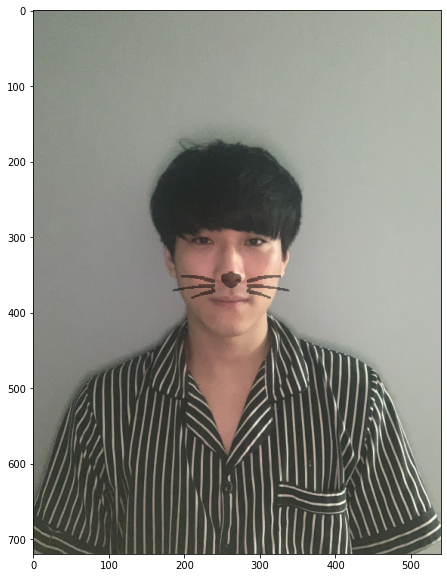

In [19]:
# 이미지 블렌딩
blending_img = cv2.addWeighted(sticker_area, 0.5,img_sticker, 0.5, 0)

# 출력 이미지에서 위와 동일한 내가 넣을 영역의 이미지를 스티커로 교환함
# 다만 png이미지를 집어넣으므로 np.where을 이용해서 투명영역에는 크롭한이미지(sticker_area) 아닌곳에는 블랜딩이미지(sticker_area)를 넣어줌
# img_show는 영역을 보기위한 테스트 이미지였으므로 깔끔한 원본이미지로 표시해봄
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,blending_img).astype(np.uint8)

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

조금더 분석 & 오류날경우?

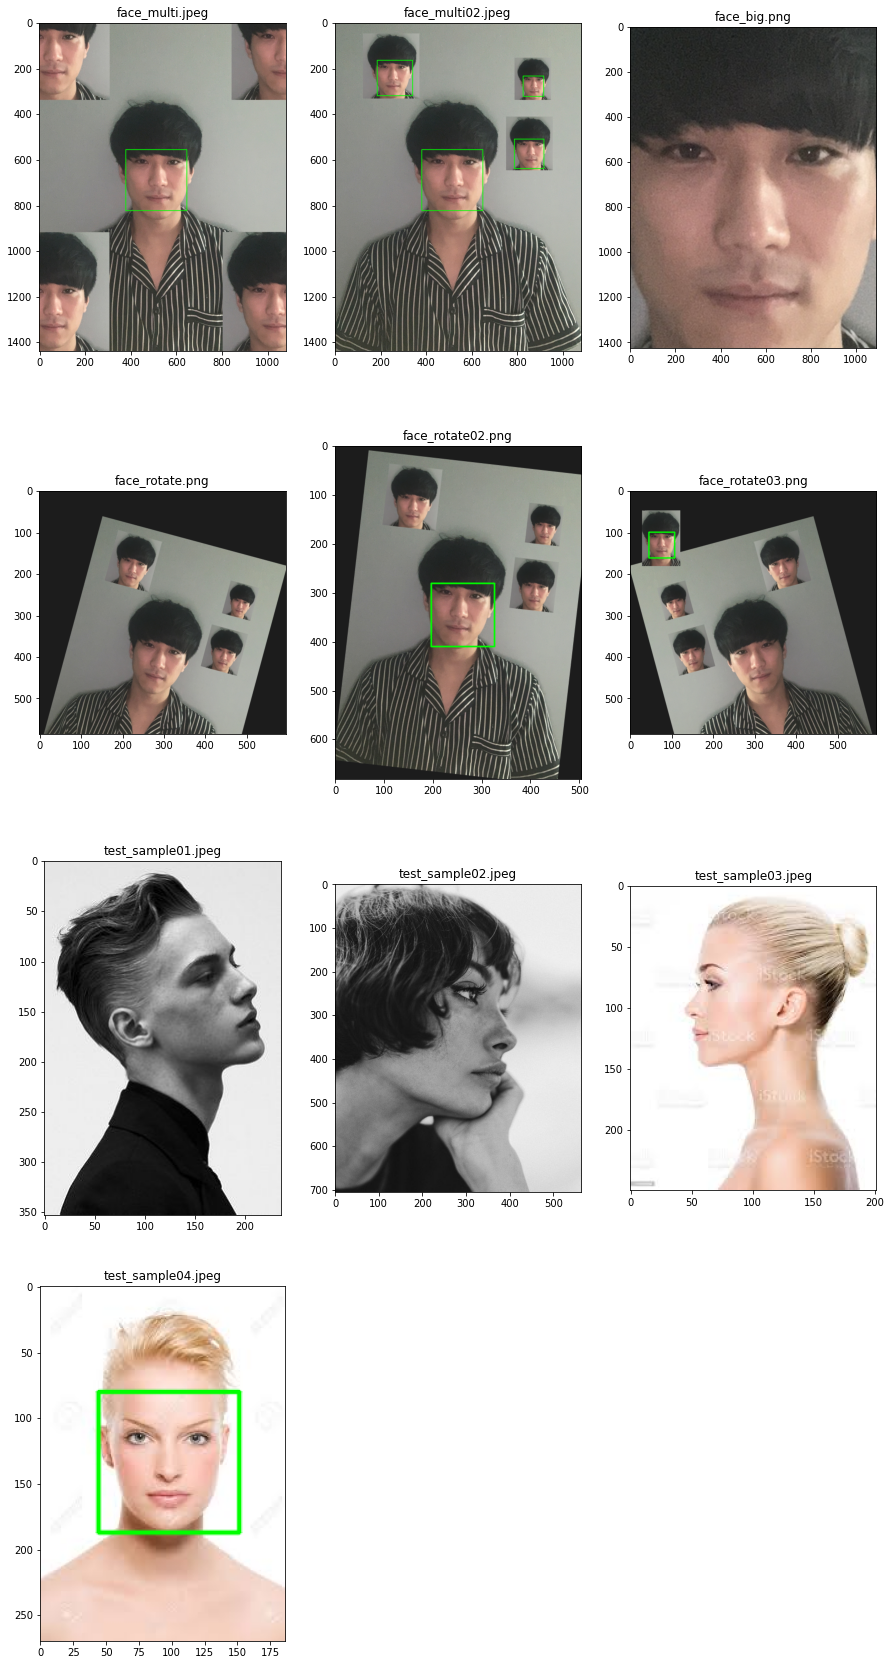

In [20]:
import matplotlib
import math
# get_frontal_face_detector 기본얼굴인식 함수 인식 범위 

plt.rcParams['figure.figsize'] = (15.0, 30.0)
# matplotlib.rcParams['font.family'] ='Malgun Gothic' 한글이없넹..
matplotlib.rcParams['axes.unicode_minus'] =False

# 얼굴 여러개
images = [
    {'title':'얼굴 전체(눈코입)이 보여야 인식함', 'file_name':'face_multi.jpeg'}, 
    {'title':'다보이면 여러개로 인식', 'file_name':'face_multi02.jpeg'},
    {'title':'또 너무크면안됨', 'file_name':'face_big.png'},
    {'title':'사진 회전되면?', 'file_name':'face_rotate.png'},
    {'title':'적당히 되면?', 'file_name':'face_rotate02.png'},
    {'title':'반대는?', 'file_name':'face_rotate03.png'},
    {'title':'test01','file_name':'test_sample01.jpeg'},
    {'title':'test02','file_name':'test_sample02.jpeg'},
    {'title':'test03','file_name':'test_sample03.jpeg'},
    {'title':'test04','file_name':'test_sample04.jpeg'}
]
col = 3
row = math.ceil(len(images)/col)
for i, image in enumerate(images): 
    i += 1
    title = image['file_name']
    plt.subplot(row, col, i) 
    plt.title(title) 
    #plt.xticks([])
    #plt.yticks([])
    
    image = cv2.cvtColor(cv2.imread(join(img_dir,image['file_name'])), cv2.COLOR_BGR2RGB)
    fill_rectangle(image, get_dlib_rects(image), 2)
    plt.imshow(image)  
plt.show()


7
